In [36]:
# Import libaries
import re
import importlib


In [37]:
# Libary to import self-made libaries
import sys # https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
sys.path.insert(1, r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Brighway\Libaries')

In [509]:
# Importing self-made libaries
import standards as s
import Monte_Carlo as MC
import life_cycle_assessment as lc
import LCA_plots as lp
import box_plot as bp

# Reload to reset the state of the self-made libaries
# https://dev.to/fronkan/importlib-reload-for-resting-modules-between-tests-neh
importlib.reload(s)
importlib.reload(MC)
importlib.reload(lc)
importlib.reload(lp)
importlib.reload(bp)

<module 'box_plot' from 'C:\\Users\\ruw\\Desktop\\RA\\Single-use-vs-multi-use-in-health-care\\Brighway\\Libaries\\box_plot.py'>

In [39]:
# Specifying if it is CONSQ (consequential) or APOS
db_type = 'CONSQ'

# Specifying the LCIA method
lcia_method = 'recipe'


In [40]:

# Path to where the code is stored
path = r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Brighway'

file_identifier = 'Ananas'
res_folder_identifier = 'Ofir'

# Specifying the file name and sheet name
file_name = f'{path}\Results\{file_identifier} - {db_type}_{lcia_method}.xlsx'
sheet_name = f'{file_identifier}'

# Creating the saving directory for the results
save_dir = s.results_folder(path, 'Results', res_folder_identifier)

# Let the use decide the project and database
database_project, database_name = lc.select_project_and_database()

# Creating the flow legend
flow_legend = ['H2R',
               'H2S',
               'ASC',
               'ASW',
               'H4R',
               'H4S',
               'ALC',
               'ALW'
               ]



Folder name Results created


The chosen project is SU_vs_MU and the chosen database is sterilization


In [41]:
flows = lc.get_database_type_flows(database_project, database_name, db_type)

flows

['H200 REC - CONSQ',
 'H200 SU - CONSQ',
 'H400 REC- CONSQ',
 'H400 SU - CONSQ',
 'alubox large + washer - CONSQ',
 'alubox large + wipe - CONSQ',
 'alubox small + washer - CONSQ',
 'alubox small + wipe - CONSQ']

In [42]:
# flows = lc.get_user_specific_flows(database_project, database_name)
# flows

In [43]:
initialization = [database_project, database_name, flows, lcia_method, db_type]
file_name_unique = f'{path}\Results\{file_identifier} - {db_type}_{lcia_method}_unq.xlsx'

In [44]:
df, plot_x_axis_all, impact_categories = lc.quick_LCIA(initialization, file_name_unique, sheet_name)

Recipe is selected
Initialization is completed
Calculating the results for acidification: terrestrial
Calculation 1/462: 'PE incineration no Energy Recovery - CONSQ' (kilogram, CH, None),  Score: -0.00020365809443248156 for col 0, row 0
Calculation 2/462: 'PP incineration no Energy Recovery - CONSQ' (kilogram, CH, None),  Score: -0.00017345619172165 for col 0, row 1
Calculation 3/462: 'alubox EoL melting - CONSQ' (kilogram, GLO, None),  Score: -0.007803120540073037 for col 0, row 2
Calculation 4/462: 'alubox production - CONSQ' (kilogram, GLO, None),  Score: 0.007834814363991858 for col 0, row 3
Calculation 5/462: 'alubox raw materials - CONSQ' (kilogram, GLO, None),  Score: 0.08981716818007165 for col 0, row 4
Calculation 6/462: 'autoclave - CONSQ' (unit, GLO, None),  Score: 0.005547151661112846 for col 0, row 5
Calculation 7/462: 'avoided alubox raw materials - CONSQ' (kilogram, GLO, None),  Score: 0.08981716818007165 for col 0, row 6
Calculation 8/462: 'cabinet washer - CONSQ' (unit

In [23]:
# df, impact_category, plot_x_axis_all, func_unit = lc.calculate_lcia(calculate=False, initialization=initialization, file_name=file_name, sheet_name=sheet_name)
# df

In [24]:
redo = False
df = lc.recalculate_lcia(redo, df, initialization, file_name, sheet_name)


In [45]:
rearrange = True
df_rearranged = lc.rearrange_dataframe_index(rearrange, df)

In [46]:
if 'recipe' in lcia_method:
    df_res, df_endpoint = lc.recipe_dataframe_split(df_rearranged)
    plot_x_axis_end = plot_x_axis_all[-3:]
    ic_mid = plot_x_axis_all[:-3] 
    plot_x_axis = []
    for ic in ic_mid:
        # print(ic)
        string = re.findall(r'\((.*?)\)', ic)
        plot_x_axis.append(string[0])

else:
    df_res = df_rearranged
    plot_x_axis = plot_x_axis_all


In [47]:
# if calculate_cont == True:
#     sub_proccess, amount = lc.obtaining_sub_process(sub_product_details)
#     FU_sub, FU_sub_process, idx = lc.sub_process_initilization(sub_proccess, FU, database_project, f'df_idx_ofir_{db_type}', lcia_method, db_type)
#     flow_count, flow_sub, functional_unit_sub = lc.FU_contibution_initilization(FU_sub, FU_sub_process)
#     fu_sub_updated = lc.process_update(FU, functional_unit_sub)
    
#     df_cont = lc.LCIA_contribution(impact_category[1], flow_count, FU_sub_process, fu_sub_updated, amount, idx)
#     lc.save_LCA_results(df_cont, file_cont_name, sheet_name, impact_category)
#     df_c = lc.import_LCA_results(file_cont_name, idx, impact_category[1])


In [518]:
df_tot, df_scaled = lc.dataframe_element_scaling(df_res)
df_col = [df_res.columns[1]]
df_GWP = df_res[df_col]

unique_elements = lc.unique_elements_list(database_name)
colors = s.plot_colors(unique_elements,'turbo')


inputs = [flow_legend, colors, save_dir, db_type, database_name]

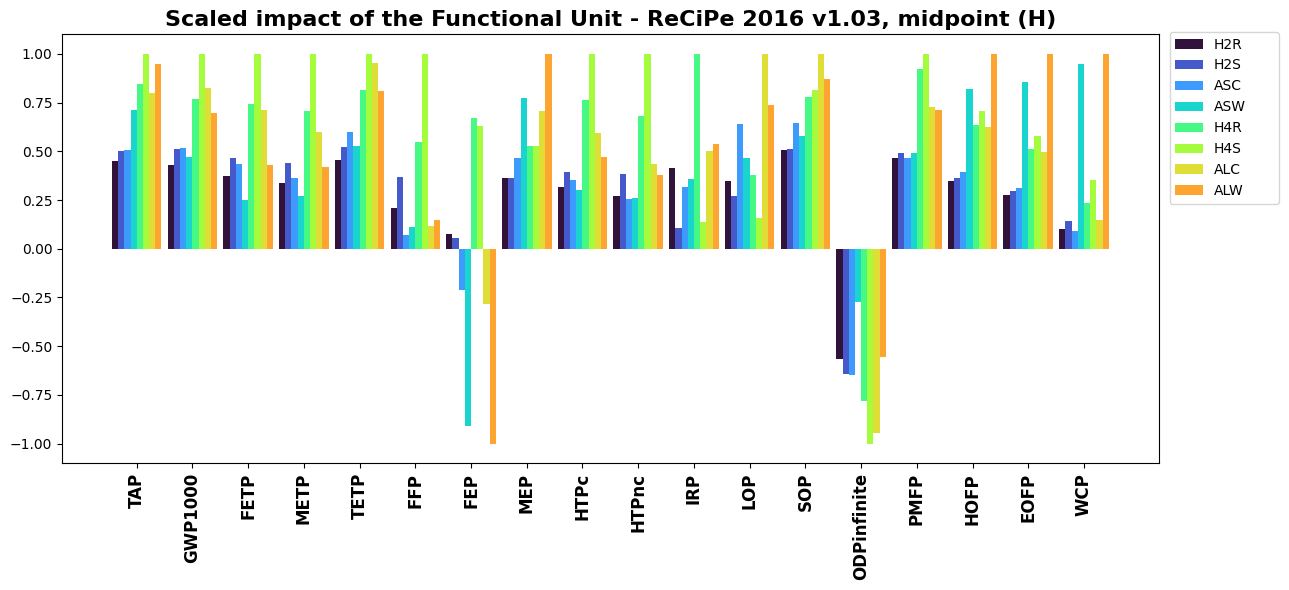

In [519]:
leg_pos_mid = .605

lp.scaled_FU_plot(df_scaled, plot_x_axis, inputs, impact_categories, leg_pos_mid)

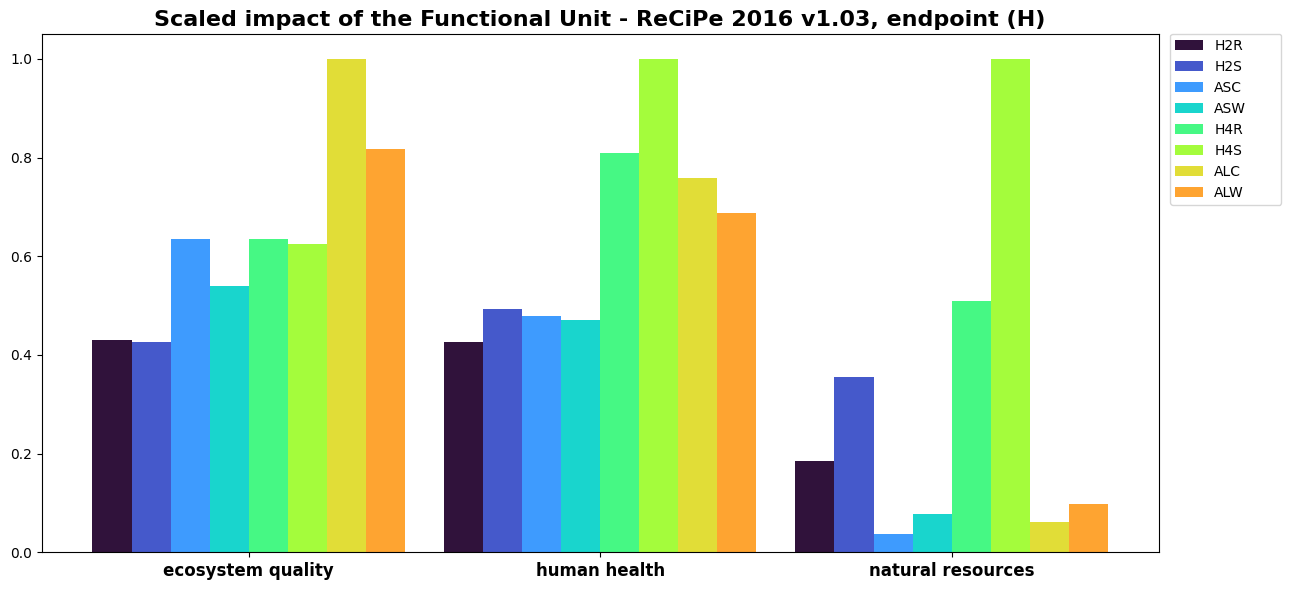

In [520]:
leg_pos_end = 0.67
if 'recipe' in lcia_method.lower():
    df_tot_e, df_scaled_e = lc.dataframe_element_scaling(df_endpoint)
    lp.scaled_FU_plot(df_scaled_e, plot_x_axis_end, inputs, impact_categories[-3:], leg_pos_end)


In [521]:
if 'recipe' not in lcia_method:
    directory = 'C:\\Users\\ruw\\Desktop\\RA\\'
    lp.single_score_plot(directory, df_tot, colors, flow_legend, save_dir, db_type)

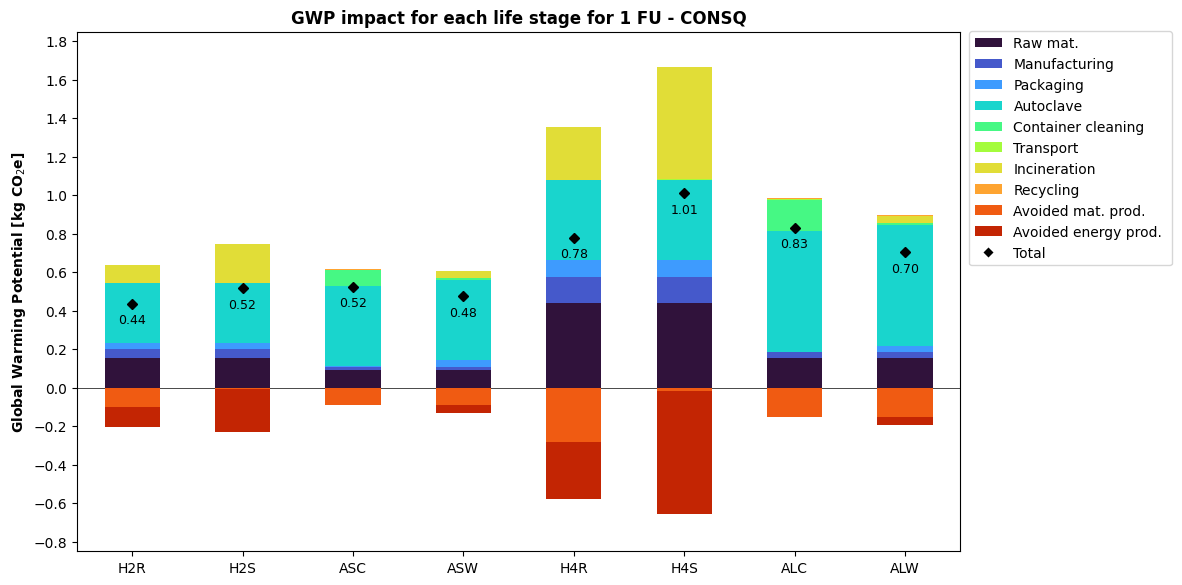

In [522]:

y_min = -.8
y_max = 1.8
step = 0.2
leg_pos = 0.55
y_axis_values = [y_min, y_max, step, leg_pos]
df_stacked = lp.gwp_scenario_plot(df_GWP, inputs, y_axis_values)


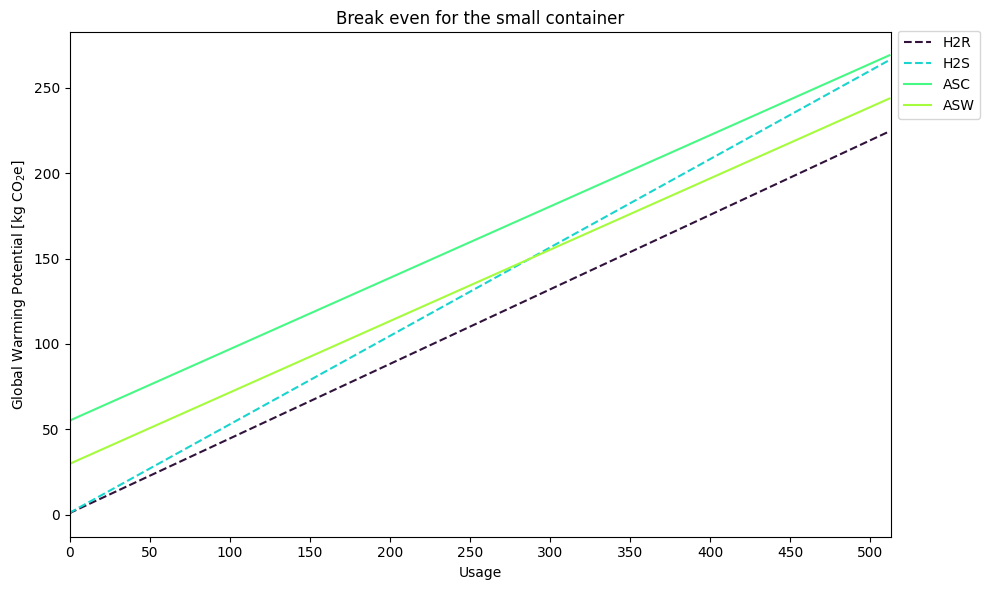

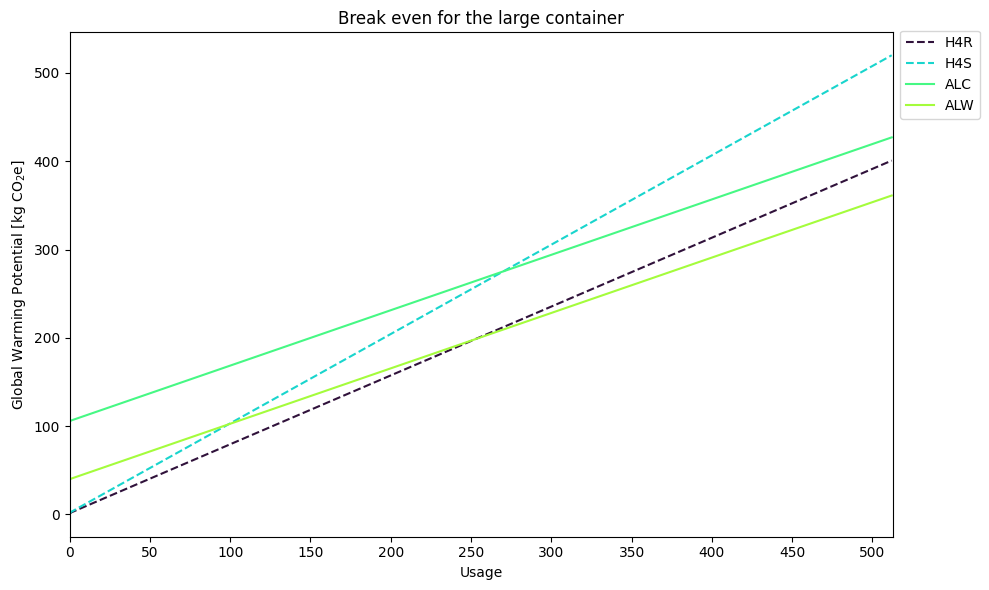

In [523]:
amount_of_uses = 513
lp.break_even_graph(df_stacked, inputs, amount_of_uses)

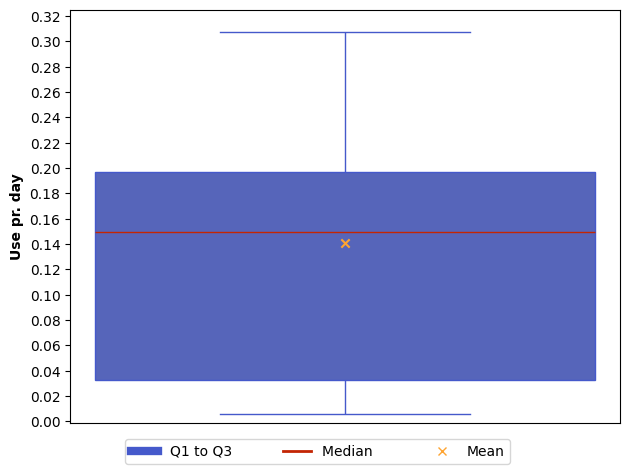

In [524]:
c0 = 1
c1 = 9
c2 = 7
plot_label = 'Use pr. day'
save_name = 'alu_container'
leg_size = 0.7
y_min = 0
y_max = 0.32
ystep = 0.02

path_box_plot = r"C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Single-use-vs-multi-use-in-health-care\Data\container.xlsx"

plot_structure = [c0, c1, c2, plot_label, save_name, leg_size, y_min, y_max, ystep]

bp.box_plot(path_box_plot, inputs, plot_structure)

In [528]:
import os
functional_unit, process, impact_category, plot_x_axis_all = lc.LCA_initialization(database_project, database_name, flows, lcia_method, db_type)


# Ensure impact categories is a list
impact_categories = list(impact_category) if isinstance(impact_category, tuple) else impact_category


# Loop through each impact category and flow

unique_process_index = []
uniquie_process = []

for f in flows:    
    # Find matches in functional units and calculate LCA
    for func_dict in functional_unit:
        for FU_key, FU_item in func_dict.items():
            if f in FU_key:
                for proc in FU_item.keys():
                    if f'{proc}' not in unique_process_index:
                        unique_process_index.append(f'{proc}')
                        uniquie_process.append(proc)

unique_process_index.sort()

uniquie_process_dct = {}

for upi in unique_process_index:
    for proc in uniquie_process:
        if upi == f'{proc}':
            uniquie_process_dct[proc] = 1

# Check if file exists
if os.path.isfile(file_name_unique): # https://stackoverflow.com/questions/82831/how-do-i-check-whether-a-file-exists-without-exceptions
    # Import LCIA results
    df_unique = lc.import_LCIA_results(file_name_unique, unique_process_index, impact_category)
    
    # Get and sort index
    df_unq_idx = sorted(df_unique.index)
    
    # Find new indices
    new_idx = [idx for i, idx in enumerate(df_unq_idx) if idx != unique_process_index[i]]
    
    # Output results
    if new_idx:
        for idx in new_idx:
            print(f'{idx} does not exist in the unique process')
    else:
        print('No new entries found')

new_idx

Recipe is selected
Initialization is completed
No new entries found


[]